# __CNN__

We decide to use CNN(convolutional neural networks) for the task of guitar tablature estimation. The previous work of Andrew Wiggins and Youngmoo Kim showed that CNNs have shown promise for translating guitar audios to tabs, and the use of CNNs has also been explored for various other tasks within music information retrieval such as musical tempo estimation, key classification, singing voice detection, and instrument classification. It is proven that CNN is a powerful tool for the purpose of our study.

## __Import libraries__

In [1]:
# Import required packages 

#various
import datetime
import pathlib
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
import warnings


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
#from tensorflow.keras import layers

#keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

# Load the TensorBoard notebook extension
%load_ext tensorboard

RSEED = 42

warnings.filterwarnings('ignore')

In [2]:
# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

2.8.0


## __Define Input Shapes__

In [3]:
#Definition of all our constants we use for our model 

FRAME_HEIGHT = 192
FRAME_WIDTH = 9
N_CLASSES = 21
N_STRINGS = 6
BATCH_SIZE = 128
EPOCHS = 8

Using Tensorboard to monitor our results:

In [4]:
#%tensorboard --logdir logs/fit

## __Load Data__

In [5]:
#we load the data from our output folder from preprocessing
INPUT_PATH = "../data/output/"
save_path = "../app/model/"

#for all
# IMAGES = np.load(INPUT_PATH + 'training_data_all_75.npz')
# annots = np.load(INPUT_PATH + 'training_labels_all_75.npz')


# for solo  
IMAGES = np.load(INPUT_PATH + 'training_datasolo_50.npz')
annots = np.load(INPUT_PATH + 'training_labelssolo_50.npz')

## __Do train & test split__

In [6]:
#First we have to split our dataset into train and test set. We use 70% for the train set and 30% for the test set.
train_images, test_images, train_annots, test_annots = train_test_split(IMAGES['arr_0'], annots['arr_0'], test_size= 0.3, shuffle=True, random_state= RSEED )

In [7]:
#Because we need also a validation set we split once more. We take this time 10% of the train set for 
#the validation set and take the rest for training.
train_images, validate_images,train_annots,validate_annots = train_test_split(train_images, train_annots, test_size = 0.1, shuffle=True, random_state = RSEED)

In [8]:
#let's have a look on the different shapes of our sets
print(train_images.shape)
print(test_images.shape)
print(validate_images.shape)
print(train_annots.shape)
print(test_annots.shape)
print(validate_annots.shape)



(78321, 192, 9)
(37296, 192, 9)
(8703, 192, 9)
(78321, 6, 21)
(37296, 6, 21)
(8703, 6, 21)


## __Define our softmax function by string__

In [9]:
def softmax_by_string(t):
        sh = K.shape(t)
        string_sm = []
        for i in range(N_STRINGS):
            string_sm.append(K.expand_dims(K.softmax(t[:,i,:]), axis=1))
        return K.concatenate(string_sm, axis=1)

In [10]:
def catcross_by_string(target, output):
        loss = 0
        for i in range(N_STRINGS):
            loss += K.categorical_crossentropy(target[:,i,:], output[:,i,:])
        return loss

In [11]:
def avg_acc(y_true, y_pred):
        return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))

## __Building our CNN Model__

In [12]:
#the function of our cnn model
'''what it takes:
- a picture with a certain frame height(192pixel) and a frame width(9 pixel)
- only one color channel, therefore as a grayscale image

what it deliver:

An array with the size 6x21. This is representing the 6 different strings of a guitar and 19 different 
frets of the guitar. The other 2 of the 21 entries represent, if a string is played or not played.

The different layers we used you can easily extract from below.
'''

def cnn_swizzle_model():       
        swizzle_model = tf.keras.Sequential()
        swizzle_model.add(tf.keras.layers.InputLayer(input_shape=[FRAME_HEIGHT, FRAME_WIDTH, 1]))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        swizzle_model.add(tf.keras.layers.Dropout(0.25))   
        swizzle_model.add(tf.keras.layers.Flatten())
        swizzle_model.add(tf.keras.layers.Dense(128, activation='relu'))
        swizzle_model.add(tf.keras.layers.Dropout(0.5))
        swizzle_model.add(tf.keras.layers.Dense(N_CLASSES * N_STRINGS))
        swizzle_model.add(tf.keras.layers.Reshape((N_STRINGS, N_CLASSES)))
        swizzle_model.add(tf.keras.layers.Activation(softmax_by_string))
        return swizzle_model

In [13]:
#this is our swizzle model
swizzle_model = cnn_swizzle_model()


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-16 11:21:56.921104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 11:21:56.921319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
#let's have a look on the model summary to see the different layers and their shapes
#we have 3 dimensions in the beginning, then flatten to 1 Dimension for the dense layers and after them
#create the end shape representing the guitar with 6 strings and 21 frets
swizzle_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 7, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 188, 5, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 3, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 1, 64)         0         
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                        

## Define model metrics for the cnn

In [15]:
'''
Metric: For our model we will use the accuracy metric, because we want to have o good overall 
prediction of our model. Besides that, for us every tone has the same importance so all classes
have the same importance.

Optimizer: As an optimizer we take the adam optimizer, which is fast enough to handle our data 
in a short time

Loss function: For the loss function we used categorical crossentropy because we have multiple classes or labels
with soft probabilities like [0.5, 0.3, 0.2] and also have a shape like a one-hot-encoded array.
'''

metrics = avg_acc

optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)

loss='categorical_crossentropy'

swizzle_model.compile(loss=catcross_by_string, optimizer=optimizer, metrics= metrics)

## Use annealer to decrease learning rate after given epochs

In [16]:
# Set a learning rate annealer
'''
With the ReduceLROnPlateau function from Keras.callbacks, 
we choose to reduce the Learning Rate by half if the accuracy is not improved after 3 epochs.
'''
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

## __Train CNN__

In [17]:
#Create folder for model 
'''This function takes the path of a new folder and create a new one. 
If the folder already exists, it will pass.'''
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

my_makedirs('../app/model')

In [18]:
csv_logger = tf.keras.callbacks.CSVLogger('../data/model/metrics_solo_50.csv')

In [19]:
#for the training we fit our model and use the batch size and epochs from our constants
history = swizzle_model.fit( train_images,
                             train_annots,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             verbose=1,
                             use_multiprocessing=True,
                             validation_data=(validate_images,validate_annots),
                             callbacks=[csv_logger],
)

swizzle_model_metrics = pd.read_csv('../data/model/metrics_solo_50.csv')
print(swizzle_model_metrics.to_markdown())

Epoch 1/8


2023-01-16 11:21:57.909155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-16 11:21:58.618443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


612/612 [==============================] - ETA: 0s - loss: 3.8096 - avg_acc: 0.8448

2023-01-16 11:22:27.623751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


612/612 [==============================] - 31s 49ms/step - loss: 3.8096 - avg_acc: 0.8448 - val_loss: 2.7848 - val_avg_acc: 0.8722
Epoch 2/8
612/612 [==============================] - 29s 48ms/step - loss: 2.8393 - avg_acc: 0.8701 - val_loss: 2.5025 - val_avg_acc: 0.8803
Epoch 3/8
612/612 [==============================] - 30s 49ms/step - loss: 2.5863 - avg_acc: 0.8811 - val_loss: 2.3410 - val_avg_acc: 0.8905
Epoch 4/8
612/612 [==============================] - 30s 48ms/step - loss: 2.4177 - avg_acc: 0.8885 - val_loss: 2.1662 - val_avg_acc: 0.8971
Epoch 5/8
612/612 [==============================] - 29s 47ms/step - loss: 2.3007 - avg_acc: 0.8939 - val_loss: 2.0669 - val_avg_acc: 0.9025
Epoch 6/8
612/612 [==============================] - 29s 47ms/step - loss: 2.2076 - avg_acc: 0.8982 - val_loss: 2.0071 - val_avg_acc: 0.9051
Epoch 7/8
612/612 [==============================] - 29s 47ms/step - loss: 2.1254 - avg_acc: 0.9017 - val_loss: 1.9573 - val_avg_acc: 0.9070
Epoch 8/8
612/612 [====

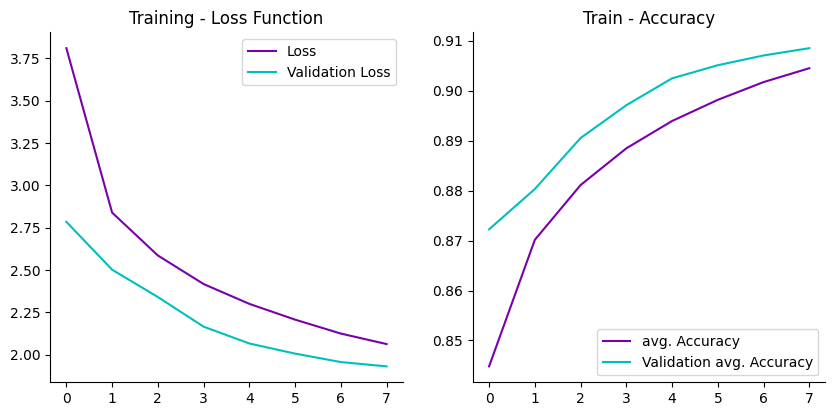

In [20]:
#show plots for our loss function and the accurancy
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss', color= '#7900AA')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'c')
plt.legend()
plt.title('Training - Loss Function')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = plt.subplot(2, 2, 2)
plt.plot(history.history['avg_acc'], label='avg. Accuracy', color = '#7900AA')
plt.plot(history.history['val_avg_acc'], label='Validation avg. Accuracy', color = 'c')
plt.legend()
plt.title('Train - Accuracy')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.savefig('../data/model/plots_solo_50.png')

In [21]:
#print results of our swizzle model metrics for training
score = swizzle_model.evaluate(test_images,test_annots,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 1.9397
Test Accuracy : 0.9097


In [22]:
#the prediction of our model will show us an array with the strings played in the
# belonging frame
model_output = swizzle_model.predict(test_images)

2023-01-16 11:26:03.512203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [23]:
#precision = precision_score(test_annots, model_output, pos_label="positive")
#print(precision)

In [24]:
#we can have look on the output arrays. We rounded them to have a better overview. 
#Thats the first entry with a size of 6 by 21.
print(test_annots.shape)
print(np.round(test_annots[:1][0],2))
print(model_output.shape)
print(np.round(model_output[:1][0],2))


(37296, 6, 21)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(37296, 6, 21)
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.11 0.   0.   0.   0.   0.02 0.03 0.81 0.03 0.01 0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [0.96 0.   0.   0.03 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0

In [25]:
# Save the entire model as a SavedModel.
swizzle_model.save('../app/model/swizzle_model_solo_50')

loaded_swizzle_model = keras.models.load_model("../app/model/swizzle_model_solo_50", compile = False)

2023-01-16 11:26:11.430975: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../app/model/swizzle_model_solo_50/assets


In [26]:
# Save and load the model output
np.save("../app/model/model_output_solo_50.npy", model_output, allow_pickle=True, fix_imports=True)

#np.load("../app/model/model_output.npy")


## __Try Swizzle-Model out in one Song!__

In [112]:
loaded_swizzle_model = keras.models.load_model("../app/model/swizzle_model_solo_50", compile = False)

In [113]:
#f_images_load = np.load('../data/output/00_BN1-129-Eb_solo_mic_data.npz')
#f_images = f_images_load['arr_0']
#f_true_load = np.load('../data/output/00_BN1-129-Eb_solo_mic_labels.npz')
#f_true = f_true_load['arr_0']

In [143]:
X_images = test_images
y_true = test_annots

In [144]:
y_pred = loaded_swizzle_model.predict(X_images)

In [145]:
np.set_printoptions(threshold=np.inf)
print(y_true.shape)
print(type(y_true.dtype))
print(y_true[1])
print(y_pred.shape)
print(type(test_annots.dtype))
print(np.round(y_pred[1]))


(37296, 6, 21)
<class 'numpy.dtype[float64]'>
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(37296, 6, 21)
<class 'numpy.dtype[float64]'>
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [146]:
test_array = np.load('test_array.npy')

In [147]:
result = []

for i in y_pred:
    corr_i = np.zeros_like(i)
    for sidx, string in enumerate(i):
        corr_i[sidx][np.argmax(string)] = 1
    
    x = np.array_equal(test_array, corr_i)
    if x == True:
        result.append(0)
    else:
        result.append(1)
print('length of the list below:',len(result),'entries')
#print(result)
df = pd.DataFrame(result)
print('1: Frames which are NOT empty!')
print('0: Frames which are empty')
df.value_counts()


length of the list below: 37296 entries
1: Frames which are NOT empty!
0: Frames which are empty


1    28279
0     9017
dtype: int64

In [148]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

print(y_true.shape)
print(y_true[20])
print('#__________________________________________________________#')
print(y_pred.shape)
y_true_ravel = y_true.ravel()

# argmax the shizzle out of the swizzle
corr_y_pred = np.zeros_like(y_pred)

for fidx, frame in enumerate(y_pred):
    for sidx, string in enumerate(frame):
        corr_y_pred[fidx][sidx][np.argmax(string)] = 1

print(corr_y_pred[20])

corr_y_pred_ravel = corr_y_pred.ravel()
print(corr_y_pred_ravel[:50])
print(y_true_ravel[:50])


(37296, 6, 21)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
#__________________________________________________________#
(37296, 6, 21)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [149]:
acc = accuracy_score(y_true_ravel, corr_y_pred_ravel)
prec = precision_score(y_true_ravel, corr_y_pred_ravel)
rec = recall_score(y_true_ravel, corr_y_pred_ravel)
f1 = f1_score(y_true_ravel, corr_y_pred_ravel)


print('#__________________________________________________________#')
print('Accuracy score:', acc)
print('#__________________________________________________________#')
print('Precision score:', prec)
print('#__________________________________________________________#')
print('Recall score:', rec)
print('#__________________________________________________________#')
print('f1_score:', f1)

#__________________________________________________________#
Accuracy score: 0.9913248707891565
#__________________________________________________________#
Precision score: 0.9119789432289432
#__________________________________________________________#
Recall score: 0.9064175279481588
#__________________________________________________________#
f1_score: 0.9091897310241132


# Data characteristics and Error analysis

In [150]:
def data_characteristics(labels: np.array, verbose: bool = True):
    dc = {
        'empty_frames': 0,
        'single_note_frames': 0,
        'multi_note_frames': 0
    }

    # empty frame
    empty = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.]]

    if labels.shape[1:] == (6, 21):

        for fidx, frame in enumerate(labels):

            if np.all(frame == empty):
                dc['empty_frames'] += 1

            else:
                # get number of notes played by number of strings played
                n_notes = 6 - sum([i[0] for i in frame])
                if n_notes == 1:
                    dc['single_note_frames'] += 1
                elif n_notes > 1:
                    dc['multi_note_frames'] += 1
                else: continue
    

    if verbose:
        print("-"*30)
        print("|", " "*5, "Label analysis", " "*5, "|")
        print("-"*30)

        for key, value in dc.items():
            if key in ['strings_correct', 'null_correct', 'fully_correct']:
                print('-'*30)

            print(f"| {key:<19}: {value:>5} |")

        print("-"*30)
    
    return dc

In [151]:
_ = data_characteristics(y_true, verbose=True)

------------------------------
|       Label analysis       |
------------------------------
| empty_frames       :  1774 |
| single_note_frames : 32798 |
| multi_note_frames  :  2724 |
------------------------------


In [152]:
def error_analysis(true: np.array, test: np.array, transform_preds: bool = True, verbose: bool = True):
    """Takes true labels and (transformed) test labels in the (n, 6, 21) shape and performs error analysis.

    Args:
        true (np.array): True labels. Shape expected (n, 6, 21)
        test (np.array): Test labels. Shape expected (n, 6, 21)
        transform_preds (bool): If true, transforms prediction probabilities to 0 or 1 using argmax. Defaults to True.
        verbose (bool): If true, prints out results. Defaults to True.
    
    Returns:
        dict: Dictionary with error analysis data.
    """

    ea = {
    'frets_correct': 0,
    'frets_wrong': 0,
    'strings_correct': 0,
    'strings_wrong': 0,
    'null_correct': 0,
    'null_wrong': 0,
    'null_total': 0,
    'fully_correct': 0,
    'part_correct': 0,
    'fully_wrong': 0,
    'total': 0
}


    # transform predictions to be [0, 1]
    if transform_preds:
        temp = np.zeros_like(test)
        for fidx, frame in enumerate(test):
            for sidx, string in enumerate(frame):
                temp[fidx][sidx][np.argmax(string)] = 1
        
        test = temp
        del temp


    # empty frame
    empty = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.],
             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.]]


    # for all frames in true labels
    for idx, frame in enumerate(true):

        # if no notes were played
        if np.all(frame == empty):

            if np.all(frame == test[idx]):
                ea['null_correct'] += 1
            else:
                ea['null_wrong'] += 1

            ea['null_total'] += 1

        # if a note was played
        else:
            # strings match
            if np.all(frame[:, 0] == test[idx][:, 0]):
                ea['strings_correct'] += 1
            
            else: 
                ea['strings_wrong'] += 1

            # frets match
            if np.all(frame[:, 1:] == test[idx][:, 1:]):
                ea['frets_correct'] += 1
            
            # only some of the frets match
            elif np.any(frame[:, 1:] == test[idx][:, 1:]):
                ea['part_correct'] += 1
                ea['frets_wrong'] += 1

            # no frets match
            elif not np.any(frame[:, 1:] == test[idx][:, 1:]):
                ea['frets_wrong'] += 1

            # nothing matches
            if not np.any(frame == test[idx]):
                ea['fully_wrong'] += 1
            
            # everything matches
            if np.all(frame == test[idx]):
                ea['fully_correct'] += 1
        
        # increase frame counter
        ea['total'] += 1
        
    if verbose:
        print("-"*26)
        print("|", " "*3, "Error analysis", " "*3, "|")
        print("-"*26)

        for key, value in ea.items():
            if key in ['strings_correct', 'null_correct', 'fully_correct']:
                print('-'*26)

            print(f"| {key:<15}: {value:>5} |")

        print("-"*26)
    
    return ea

In [153]:
errors = error_analysis(y_true, y_pred, transform_preds=True, verbose=True)

--------------------------
|     Error analysis     |
--------------------------
| frets_correct  : 19049 |
| frets_wrong    : 16473 |
--------------------------
| strings_correct: 23186 |
| strings_wrong  : 12336 |
--------------------------
| null_correct   :  1320 |
| null_wrong     :   454 |
| null_total     :  1774 |
--------------------------
| fully_correct  : 19049 |
| part_correct   : 16473 |
| fully_wrong    :     0 |
| total          : 37296 |
--------------------------
